In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
import channelparams
from shooting import *
from theory import *
from utils import *

fbc = channelparams.fbc.copy()
r = fbc['rsill']

In [4]:
ds = xr.open_dataset("../data/critical_1d_log.nc")

In [31]:
tol = 0.005
ds['critical'] = ds['match'] < tol
ds['critical'].attrs = {'tolerance': tol}

βcrit = ds['β'].where(ds['critical'] & (ds['mode']==5.)).mean(skipna=True).values

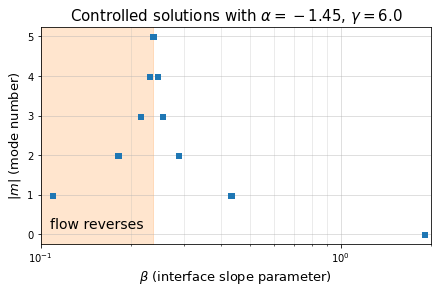

In [141]:
plt.figure(figsize=(7,4))
plt.fill_betweenx([-1, 6], [0.1, 0.1], [βcrit, βcrit], color="C1", alpha=0.2)
ds['mode'].where(ds['critical']).plot(marker="s", markersize=5)
plt.xscale("log")
plt.grid(True, alpha=0.5, which="major")
plt.grid(True, alpha=0.3, which="minor")
α = ds.attrs['α']
γ = ds.attrs['γ']
plt.xlabel(r"$\beta$ (interface slope parameter)", fontsize=13)
plt.ylabel(r"$|m|$ (mode number)", fontsize=13)
plt.title(fr"Controlled solutions with $\alpha={α}$, $\gamma={γ}$", fontsize=15)
plt.xlim(0.1, 2.)
plt.ylim(-0.25, 5.25)
plt.annotate(text="flow reverses", xy=(0.1075, 0.15), fontsize=14)
plt.savefig("../figures/control_regime_1d.png", bbox_inches="tight", dpi=150)

In [143]:
βmodes = {}
argmins = {}
for m in range(5):
    βmodes[f"{m}"] = ds['β'].isel(β=ds['match'].where(ds['critical'] & (ds['mode']==m) & (ds['β'] > βcrit)).argmin(skipna=True)).values
    argmins[f"{m}"] = ds['match'].where(ds['critical'] & (ds['mode']==m) & (ds['β'] > βcrit)).argmin(skipna=True).values
for m in range(1,5):
    βmodes[f"-{m}"] = ds['β'].isel(β=ds['match'].where(ds['critical'] & (ds['mode']==m) & (ds['β'] < βcrit)).argmin(skipna=True)).values
    argmins[f"-{m}"] = ds['match'].where(ds['critical'] & (ds['mode']==m) & (ds['β'] < βcrit)).argmin(skipna=True).values

In [144]:
βmodes

{'0': array(1.89967249),
 '1': array(0.42922234),
 '2': array(0.28718888),
 '3': array(0.25456726),
 '4': array(0.24433307),
 '-1': array(0.10877848),
 '-2': array(0.17986515),
 '-3': array(0.2151127),
 '-4': array(0.22996634)}

In [145]:
argmins

{'0': array(29484609),
 '1': array(14588802),
 '2': array(10564728),
 '3': array(9357260),
 '4': array(8946348),
 '-1': array(842632),
 '-2': array(5878735),
 '-3': array(7670831),
 '-4': array(8339491)}

1.721034920576179
0.20121752230535334
0.05363825221023161
0.01972291636281212
0.00908131640087212
-0.13193903166969
-0.057969919016737426
-0.021306331098050996
-0.005858574449703419


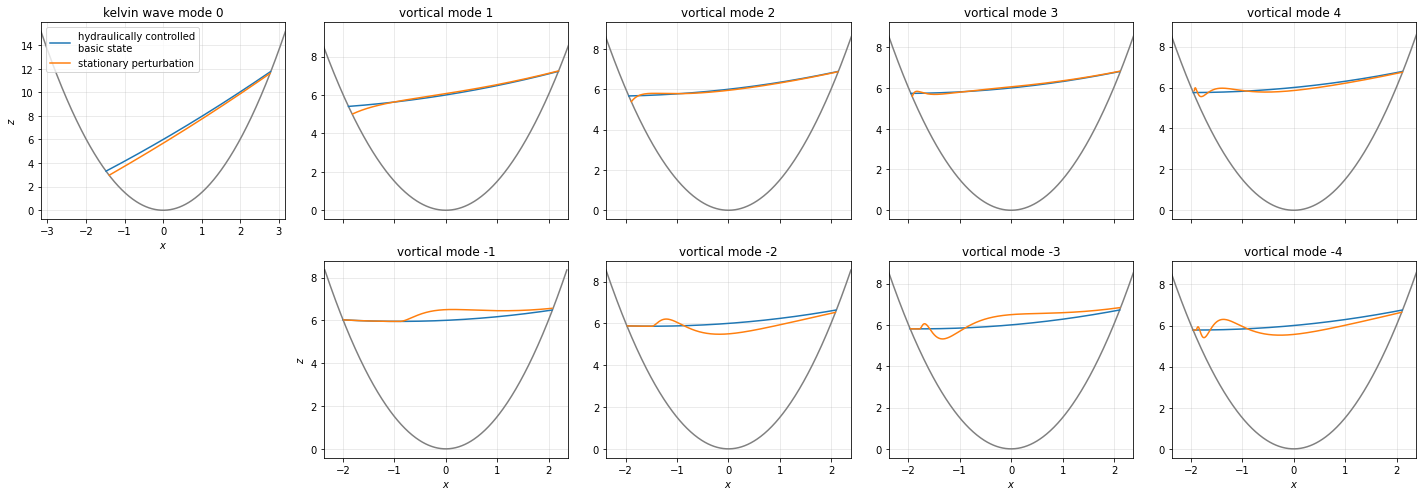

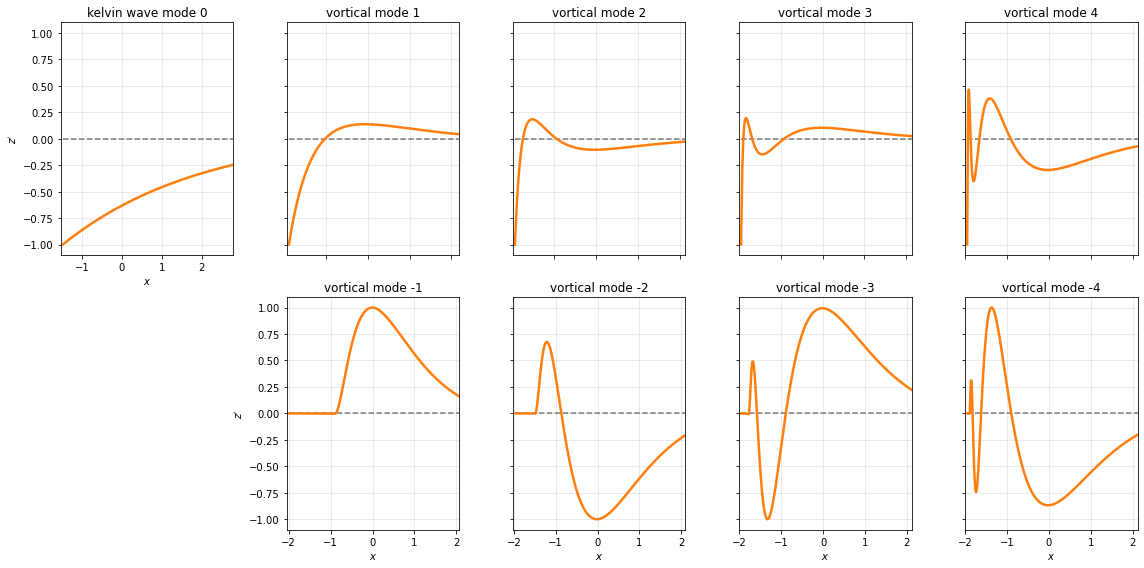

In [147]:
fig1 = plt.figure(num=1, figsize=(20,7))
fig2 = plt.figure(num=2, figsize=(16,8))

α = ds.attrs['α']
γ = ds.attrs['γ']

nx = 400
for i, (m, β) in enumerate(βmodes.items(), start=1):
    outputs = shoot_perturbations(α, β, γ, r, nx)
    x = outputs['x'][:outputs['zp'].size]

    h = x**2/r
    d = α*x**2 + β*x + γ
    η = d+h
    η[d<0.] = np.nan
    d[d<0.] = np.nan

    v = (2.*(α + 1/r)*x + β)
    print(np.min(v))
    
    xwide = np.linspace(-np.max(np.abs(x))*1.135, np.max(np.abs(x))*1.135, nx)
    hwide = xwide**2/r

    ii=i + (i>=6);
    
    ####
    plt.figure(num=1)
    plt.subplot(2,5,ii)
    plt.plot(xwide, hwide, color="grey")
    plt.plot(x, η, "C0")
    plt.grid(True, alpha=0.3)
    ηp = np.copy(η+0.5*outputs['zp']/np.max(np.abs(outputs['zp'])))
    ηp[ηp < h] = np.nan
    plt.plot(x, ηp, "C1")
    match = outputs["match"]
    if i==1:
        plt.title(f"kelvin wave mode {m}")
        plt.plot([],[],"C0", label="hydraulically controlled\nbasic state")
        plt.plot([],[],"C1", label="stationary perturbation")
        plt.legend(loc="upper left", fontsize=10)
    else:
        plt.title(f"vortical mode {m}")
    plt.xlim(np.min(xwide), np.max(xwide))
    
    xt, xtl = plt.xticks()
    if (i==1) | (i>=6):
        plt.xlabel(r"$x$")
    else:
        plt.xticks(xt, ["" for l in xtl])
    if i>1:
        plt.xlim(-2.375, 2.375)
        
    if (i==1) | (i==6):
        plt.ylabel(r"$z$")
    else:
        plt.ylabel("")
    
    ####
    plt.figure(num=2)
    plt.subplot(2,5,ii)
    plt.grid(True, alpha=0.3)
    plt.plot(x, x*0.,'k--',alpha=0.5)
    plt.plot(x, outputs['zp']/np.max(np.abs(outputs['zp'])), "C1-", linewidth=2.5)
    if i==1:
        plt.title(f"kelvin wave mode {m}")
    else:
        plt.title(f"vortical mode {m}")
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(-1.1, 1.1)
    
    yt, ytl = plt.yticks()
    if (i==1) | (i==6):
        plt.ylabel(r"$z'$")
    else:
        plt.ylabel("")
        plt.yticks(yt, ["" for l in ytl])
    
    xt, xtl = plt.xticks()
    if (i==1) | (i>=6):
        plt.xlabel(r"$x$")
    else:
        plt.xticks(xt, ["" for l in xtl])
    plt.xlim(np.min(x)-0.05, np.max(x))
    plt.ylim(-1.1, 1.1)

plt.figure(1)
plt.tight_layout()
plt.savefig("../figures/stationary_waves.png", dpi=150.,bbox_inches="tight")

plt.figure(2)
plt.tight_layout(w_pad=0.01)
plt.savefig("../figures/stationary_wave_modal_structure.png", dpi=150.,bbox_inches="tight")